In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sp_signal
from pymultifracs.viz import plot_psd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "scripts")))
from simulation import generate_synthetic_neural_signal
from decomposition import run_all_decompositions
from plotting import plot_signal_and_modes
from evaluation import summarize_decomposition_results
from pymultifracs import mfa, wavelet_analysis


### 🎯 Experiment Overview: Signal Composition vs Decomposition Behavior

| Signal Name                   | Composition Details                                  | Known # of Components (Modes) |
|-------------------------------|-----------------------------------------------------|-------------------------------|
| **Pure Oscillations**         | 6 Hz + 10 Hz + 30 Hz + 80 Hz                         | 4                             |
| **Pure Oscillations + 1/f**    | Same as above + 1/f noise                           | 4 + noise                     |
| **MRW Modulated Oscillations** | MRW modulated 6, 10, 30, 80 Hz                       | 4 modulated                   |
| **MRW + 1/f**                  | MRW modulated 6, 10, 30, 80 Hz + 1/f noise           | 4 modulated + noise           |
| **MRW (H, lam) + 1/f**         | MRW (H=0.8, lam=0.05) modulated 6, 10, 30, 80 Hz + 1/f noise | 4 modulated + noise |

### 🧪 Objective:
- Set **Nmodes = 4** in all decompositions.
- Observe how **EMD**, **VMD**, and **VMDtransformer** behave:
  - Do they **stop at 4 modes** as expected?
  - Do they **capture the known components** or **over/under decompose**?


## 1. Signal generation

In [3]:
# 1. Pure oscillations (no modulation, no noise)
pure = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.0,
    c2=0.0
)

# 2. MRW-modulated oscillations (no noise)
mrw_modulated = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.7,
    c2=-0.04
)

# 3. MRW + FBM noise (most realistic)
mrw_with_fbm = generate_synthetic_neural_signal(
    add_fbm_noise=True,
    add_powerline=False,
    c1=0.7,
    c2=-0.04,
    H=0.98  # Hurst exponent for FBM
)


Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Filter length: 551 samples (2.204 s)

Setting up high-pass filter at 2.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 413 samples (1.652 s)

Setting up high-pass filter at 7.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) me

## 2. Signal exploration

In [4]:
mod  = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.7,
    c2=-0.04
)

Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Filter length: 551 samples (2.204 s)

Setting up high-pass filter at 2.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 413 samples (1.652 s)

Setting up high-pass filter at 7.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) me

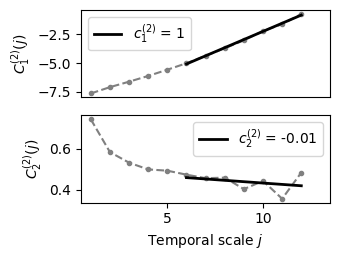

In [5]:
pwt = mfa(wavelet_analysis(mod["modulator"], 'db4').integrate(1).get_leaders(2), [(6, 12)])
pwt.cumulants.plot()

In [ ]:
# Prepare data
signal_dicts = [pure, mrw_modulated, mrw_with_fbm]
titles = ["Pure Oscillation", "MRW-Modulated", "MRW + FBM Noise"]

n_samples_to_plot = int(fs * duration)
t_full = signal_dicts[0]['time'][:n_samples_to_plot]
fs = 250  # Sampling frequency


# Downsampling step
step = max(1, int(n_samples_to_plot / max_points)) if max_points is not None else 1
t = t_full[::step]

# Plot
plt.figure(figsize=(15, 10))

for i, (signal_dict, title) in enumerate(zip(signal_dicts, titles)):
    y_full = signal_dict['final_signal'][:n_samples_to_plot]
    y = y_full[::step]
    plt.subplot(len(signal_dicts), 1, i + 1)
    plt.plot(t, y)
    plt.title(title)
    plt.ylabel("Amplitude")
    if i == len(signal_dicts) - 1:
        plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()

In [ ]:

for signal, title in zip(signal_list, titles):
    plot_psd(signal, fs=fs)
    plt.title(f"PSD - {title}")
    plt.show()


## 3. Signal decomposition

In [ ]:
output_base = "../results/synthetic"
signal_list = [pure["final_signal"], mrw_modulated["final_signal"], mrw_with_fbm["final_signal"]]
signal_names = ["pure", "mrw_modulated", "mrw_with_fbm"]

# PARAMETERS
fs = 250  # Hz
duration = 300.0       # Duration to plot (in seconds)
max_points = 1000      # Optional: downsample to this number of points

In [48]:
n_modes = 4
max_imfs = 8
max_modes = 8
methods = [#"EMD",
           "VMD"
            #",VMDtransformer"
            ]


for signal, name in zip(signal_list, signal_names):
    print(f"--- Processing: {name} ---")
    output_dir = os.path.join(output_base, name)
    os.makedirs(output_dir, exist_ok=True)

    # Apply all decompositions
    feats_dict, modes_dict = run_all_decompositions(signal_in=signal,
                                                    methods=methods,
                                                    Fs=fs,
                                                    Nmodes=n_modes,
                                                    MaxEmdIMF=max_imfs,
                                                    MaxVmdModes = max_modes,
                                                    return_modes=True
                                                    #eemd_trials=50,    # Fewer EEMD trials for speed
                                                    #vmd_alpha=500,     # Stronger constraint on bandwidth
                                                    #vmd_tau=1,         # Higher noise tolerance
                                                    #vmd_DC=1,          # DC mode extraction
                                                    #vmd_init=1,        # Initialization strategy
                                                    #vmd_tol=1e-6       # Relaxed convergence tolerance
                                                    )

    for method in feats_dict:
        method_dir = os.path.join(output_dir, method)
        os.makedirs(os.path.join(method_dir, "modes"), exist_ok=True)
        os.makedirs(os.path.join(method_dir, "features"), exist_ok=True)
        os.makedirs(os.path.join(method_dir, "figures"), exist_ok=True)


        # Save modes
        np.save(os.path.join(method_dir, "modes", f"{name}_modes.npy"), modes_dict[method])

        # Plot signal + spectrum + modes
        plot_signal_and_modes(
            x=signal,
            sfreq=fs,
            duration = 300,
            max_points = 1000,
            modes=modes_dict[method],
            method=method,
            ch=0,
            output_dir=output_dir,
)

        # Save features
        labels = feats_dict[method]["labels"]
        values = feats_dict[method]["values"]
        df = pd.DataFrame([values], columns=labels)
        df.to_csv(os.path.join(method_dir, "features", f"{name}_features.csv"), index=False)

        print(f"Saved {method} for {name}")



--- Processing: pure ---
Saved VMD for pure
--- Processing: mrw_modulated ---
Saved VMD for mrw_modulated
--- Processing: mrw_with_fbm ---
Saved VMD for mrw_with_fbm


In [49]:
report_df = summarize_decomposition_results(
    signal_list=signal_list,          # list of signals you processed
    signal_names=signal_names,        # corresponding names
    sfreq=250,                        # your sampling frequency
    base_dir="../results/synthetic",     # change if you're saving somewhere else
    n_modes_to_use=4                  # how many modes to use in partial reconstruction
)


In [56]:
report_df.to_csv("../results/synthetic/report_synthetic.csv")

In [50]:
report_df.head(100)

,Method,Signal,Mode Index,Peak Frequency (Hz),Reconstruction MSE (Full),Reconstruction MSE (First N Modes),Number of Extracted Modes
0,EMD,pure,0,80.000000,2.598572e-40,1.356596e-03,9
1,EMD,pure,1,30.000000,2.598572e-40,1.356596e-03,9
2,EMD,pure,2,10.000000,2.598572e-40,1.356596e-03,9
3,EMD,pure,3,6.000000,2.598572e-40,1.356596e-03,9
4,EMD,pure,4,2.000000,2.598572e-40,1.356596e-03,9
5,EMD,pure,5,0.054545,2.598572e-40,1.356596e-03,9
6,EMD,pure,6,0.036364,2.598572e-40,1.356596e-03,9
7,EMD,pure,7,0.039394,2.598572e-40,1.356596e-03,9
8,EMD,pure,8,0.027273,2.598572e-40,1.356596e-03,9
9,EMD,mrw_modulated,0,80.000000,3.492071e-36,2.566337e-01,9


In [54]:
# import numpy as np
# import matplotlib.pyplot as plt
# from PyEMD import EMD

# # Time axis
# fs = 1000
# t = np.linspace(0, 1, fs)

# # True components
# c1 = np.sin(2 * np.pi * 5 * t)
# c2 = np.sin(2 * np.pi * 20 * t)
# c3 = np.sin(2 * np.pi * 60 * t)
# signal = c1 + c2 + c3

# # EMD decomposition
# emd = EMD()
# imfs = emd.emd(signal, t)

# # Plot
# fig, axes = plt.subplots(5, 1, figsize=(12, 8), sharex=True)
# fig.suptitle("Empirical Mode Decomposition (EMD)", fontsize=14)

# axes[0].plot(t, signal, color='black')
# axes[0].set_ylabel("Original Signal")

# axes[1].plot(t, c1, label='5 Hz', linestyle='--')
# axes[1].plot(t, c2, label='20 Hz', linestyle='-.')
# axes[1].plot(t, c3, label='60 Hz', linestyle=':')
# axes[1].legend()
# axes[1].set_ylabel("True Components")

# for i in range(min(3, imfs.shape[0])):
#     axes[i+2].plot(t, imfs[i])
#     axes[i+2].set_ylabel(f"IMF {i+1}")

# axes[-1].set_xlabel("Time (s)")
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()
